# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

# Prepare Generators and Variables Initialization

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


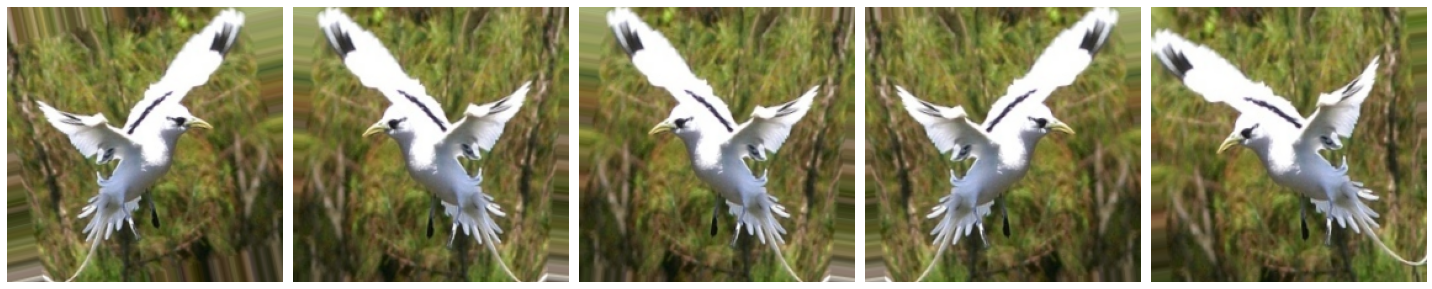

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Build model and train model

In [3]:
base_vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Freezing the weights
for layer in base_vgg16.layers:
    layer.trainable = False

base_vgg16.summary();

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# use “get_layer” method to save the last layer of the network
last_layer = base_vgg16.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add our new softmax layer with 3 hidden units
x = Dense(nr_birds, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_vgg16.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath='./checkpoints/birds.model.hdf5', save_best_only=True)

history = new_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1)])

Epoch 1/30
96/96 [==============================] - 716s 7s/step - loss: 2.2825 - accuracy: 0.3755 - val_loss: 1.5407 - val_accuracy: 0.6200
Epoch 2/30
96/96 [==============================] - 691s 7s/step - loss: 1.3295 - accuracy: 0.7129 - val_loss: 0.9605 - val_accuracy: 0.8100
Epoch 3/30
96/96 [==============================] - 694s 7s/step - loss: 0.9504 - accuracy: 0.8086 - val_loss: 0.7711 - val_accuracy: 0.8100
Epoch 4/30
96/96 [==============================] - 698s 7s/step - loss: 0.7660 - accuracy: 0.8441 - val_loss: 0.5818 - val_accuracy: 0.8700
Epoch 5/30
96/96 [==============================] - 696s 7s/step - loss: 0.6427 - accuracy: 0.8691 - val_loss: 0.4764 - val_accuracy: 0.9100
Epoch 6/30
96/96 [==============================] - 694s 7s/step - loss: 0.5414 - accuracy: 0.8944 - val_loss: 0.4456 - val_accuracy: 0.9000
Epoch 7/30
96/96 [==============================] - 685s 7s/step - loss: 0.4695 - accuracy: 0.9135 - val_loss: 0.4009 - val_accuracy: 0.8900
Epoch 8/30
96

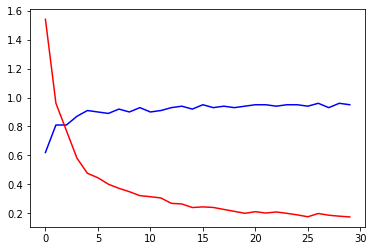

In [7]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

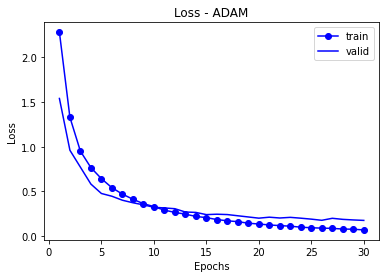

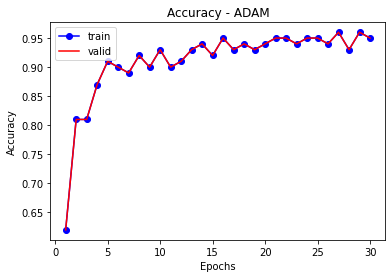

best val_acc: 0.9599999785423279 epoch: 26
best val_loss: 0.1749657243490219 epoch: 0


In [16]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["val_accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, loss_values, "b", marker = "o", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss - ADAM")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc_values, "b", marker = "o", label="train")
plt.plot(epochs, val_acc_values, "r", label="valid")
plt.title("Accuracy - ADAM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmax(val_loss_values))

# Testing 

In [8]:
test_loss, test_acc = new_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 18s 4s/step - loss: 0.1387 - accuracy: 0.9600
Test Accuracy: 0.9599999785423279


In [ ]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [ ]:
# we use the validation data to verify the accuracy
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Valid Accuracy:", accuracy)

In [ ]:
# we use the test data to verify the accuracy
accuracy = get_accuracy(new_model, data_test, labels_test)
print("Test Accuracy:", accuracy)

In [9]:
new_model.save('./models/cnn_model.h5')

## Running Predictions From Saved Model

In [10]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(os.listdir(train_path)))
  print(all_birds_cat)
  for i, pred in enumerate(predicted_arr):
    print(np.argmax(pred))
    return all_birds_cat[np.argmax(pred)]


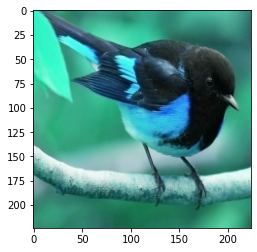

['AMERICAN REDSTART' 'BARRED PUFFBIRD' 'BELTED KINGFISHER'
 'CAPE MAY WARBLER' 'CREAM COLORED WOODPECKER' 'CRESTED CARACARA'
 'EASTERN MEADOWLARK' 'EASTERN TOWEE' 'EUROPEAN GOLDFINCH' 'HOATZIN'
 'HOOPOES' 'IBERIAN MAGPIE' 'IMPERIAL SHAQ' 'KOOKABURRA'
 'RED BELLIED PITTA' 'RUFUOS MOTMOT' 'TAIWAN MAGPIE' 'TREE SWALLOW'
 'VIOLET GREEN SWALLOW' 'WHITE TAILED TROPIC']
0
AMERICAN REDSTART


In [12]:

model = load_model('./models/cnn_model.h5')

predict_image_path = './dataset/20test/AMERICAN REDSTART/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)
label = decode(predictions)

print(label)